In [4]:

import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
import networkx as nx
#import yfinance as yf

import DyGraph as dg
import matplotlib.pyplot as plt
import tqdm
import scipy
import pickle
import seaborn as sns
import datetime

import port_measures as pm


# ETF portfolio case study

Run CaseStudyETF.py and CaseStudy_static.py for the results. Note group-t, skew-group-t, block-wise and perturbed-node will take some time

In [2]:



dgaussian_ew = dict()
dgaussian_ridge = dict()
dgaussian_gr = dict()
dgaussian_bwr = dict()
dgaussian_pn = dict()

dt_ew = dict()
dt_ridge = dict()
dt_gr = dict()
dt_bwr = dict()
dt_pn = dict()

dgt_ew = dict()
dsgt_ew = dict()

with open(f'data/static_gaussian_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    sgaussian = pickle.load(handle)
with open(f'data/static_t_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    st = pickle.load(handle)
with open(f'data/ledoitwolf_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    ledoitwolf = pickle.load(handle)
with open(f'data/empirical_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    empirical = pickle.load(handle)
with open(f'data/group-t_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    sgt = pickle.load(handle)
with open(f'data/skew-group-t_nr_quad_10_etf_k3.pkl', 'rb') as handle:
    ssgt = pickle.load(handle)


# with open(f'../data/NAAJ_pension/gaussian_nr_quad_10_etf_k_{0.01}_element-wise3.pkl', 'rb') as handle:
#     dgaussian_ew[str(0.01)] = pickle.load(handle)
# with open(f'../data/NAAJ_pension/t_nr_quad_10_etf_k_{0.01}_element-wise3.pkl', 'rb') as handle:
#     dt_ew[str(0.01)] = pickle.load(handle)



for k in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    with open(f'data/gaussian_nr_quad_10_etf_k_{k}_element-wise3.pkl', 'rb') as handle:
        dgaussian_ew[str(k)] = pickle.load(handle)
    with open(f'data/gaussian_nr_quad_10_etf_k_{k}_ridge3.pkl', 'rb') as handle:
        dgaussian_ridge[str(k)] = pickle.load(handle)
    with open(f'data/gaussian_nr_quad_10_etf_k_{k}_global-reconstruction3.pkl', 'rb') as handle:
        dgaussian_gr[str(k)] = pickle.load(handle)
    # with open(f'../data/NAAJ_pension/gaussian_nr_quad_10_etf_k_{k}_block-wise-reconstruction2.pkl', 'rb') as handle:
    #     dgaussian_bwr[str(k)] = pickle.load(handle)
    # with open(f'../data/NAAJ_pension/gaussian_nr_quad_10_etf_k_{k}_perturbed-node2.pkl', 'rb') as handle:
    #     dgaussian_pn[str(k)] = pickle.load(handle)

    with open(f'data/t_nr_quad_10_etf_k_{k}_element-wise3.pkl', 'rb') as handle:
        dt_ew[str(k)] = pickle.load(handle)
    with open(f'data/t_nr_quad_10_etf_k_{k}_ridge3.pkl', 'rb') as handle:
        dt_ridge[str(k)] = pickle.load(handle)
    with open(f'data/t_nr_quad_10_etf_k_{k}_global-reconstruction3.pkl', 'rb') as handle:
        dt_gr[str(k)] = pickle.load(handle)
        
with open(f'data/t_nr_quad_10_etf_k_{0.1}_block-wise-reconstruction2.pkl', 'rb') as handle:
    dt_bwr[str(0.1)] = pickle.load(handle)
with open(f'data/t_nr_quad_10_etf_k_{0.1}_perturbed-node2.pkl', 'rb') as handle:
    dt_pn[str(0.1)] = pickle.load(handle)

with open(f'data/group-t_nr_quad_10_etf_k_{0.1}_element-wise3.pkl', 'rb') as handle:
    dgt_ew[str(0.1)] = pickle.load(handle)

with open(f'data/skew-group-t_nr_quad_10_etf_k_{0.1}_element-wise3.pkl', 'rb') as handle:
    dsgt_ew[str(0.1)] = pickle.load(handle)



## Do uniform 

In [8]:

with open(f'data/raw_etf2.pkl', 'rb') as handle:
    data = pickle.load(handle)

ticker_list = data['ticker_list']
#log_returns = data['log_returns']
log_returns_scaled = data['log_returns_scaled']
price = data['price']

l = 60
time_index = range(360,2980, l)



In [18]:


alphas = np.array([0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.4, 0.6, 0.8, 1.2])[::-1]
sharpes_u = {i: [] for i in range(len(alphas))}
ws_u = {i: [] for i in range(len(alphas))}
mus_u = {i: [] for i in range(len(alphas))}
vars_u = {i: [] for i in range(len(alphas))}
rs_u = {i: [] for i in range(len(alphas))}
omegas_u = {i: [] for i in range(len(alphas))}
mdds_u = {i: [] for i in range(len(alphas))}
port_price_u = {i: [] for i in range(len(alphas))}
sigmas_u = {i: [] for i in range(len(alphas))}
time_forecast = {i: [] for i in range(len(alphas))}


for alpha_cnt, alpha in enumerate(alphas):
    for time_cnt, i in enumerate(time_index):

        lwr = np.max((i-180,0))
        mu = np.mean(log_returns_scaled.iloc[lwr:i],axis = 0)
        S = np.identity(11)


        # Update precision matrix 
        precision_matrix = np.linalg.inv(S) 

        # portfolio weights sharpe
        w_u, mu_u, var_u = pm.portfolio_opt(S, precision_matrix, mu, log_returns_scaled[lwr:i], type = 'uniform')

        portfolio_u = np.dot(price.iloc[i:i + l],w_u)
        port_price_u[alpha_cnt].append(portfolio_u)
        log_returns_s = np.array(100*np.log(1+pd.DataFrame(portfolio_u).pct_change()).dropna())
        r_s = (portfolio_u[-1]-portfolio_u[0])/portfolio_u[0]
        sigma_u = np.std(log_returns_s)
        sharpe_u = pm.sharpe(r_s,sigma_u)
        sharpes_u[alpha_cnt].append(sharpe_u)
        mdds_u[alpha_cnt].append(pm.max_drawdown(portfolio_u))
        omegas_u[alpha_cnt].append(pm.omega(np.squeeze(log_returns_s)))
        ws_u[alpha_cnt].append(w_u)
        mus_u[alpha_cnt].append(mu_u)
        vars_u[alpha_cnt].append(var_u)
        rs_u[alpha_cnt].append(r_s)
        sigmas_u[alpha_cnt].append(sigma_u)



uniform_dict = {'alphas':alphas, 'time_index':time_index, 'time_change':price.index[time_index], 'time_forecast':time_forecast, 'ticker_list':ticker_list, 
            'portfolio_u': portfolio_u, 'portfolio_s':portfolio_u, 'portfolio_m':portfolio_u,
            'port_price_u': port_price_u, 'port_price_s':port_price_u, 'port_price_m':port_price_u,
            'sharpes_u': sharpes_u, 'sharpes_s':sharpes_u, 'sharpes_m':sharpes_u,
            'mdds_u': mdds_u, 'mdds_s':mdds_u, 'mdds_m':mdds_u,
            'omegas_u': omegas_u, 'omegas_s':omegas_u, 'omegas_m':omegas_u,
            'ws_u': ws_u, 'ws_s':ws_u, 'ws_m':ws_u,
            'mus_u': mus_u, 'mus_s':mus_u, 'mus_m':mus_u,
            'vars_u': vars_u, 'vars_s':vars_u, 'vars_m':vars_u,
            'rs_u': rs_u, 'rs_m':rs_u, 'rs_s':rs_u,
            'sigmas_u': sigmas_u, 'sigmas_m':sigmas_u, 'sigmas_s':sigmas_u}


In [13]:
def plot_stat(var, l, legends, ax = None):



    var_agg = [[] for i in range(len(l))]
    var_agg_std = [[] for i in range(len(l))]


    for i in range(len(l)):

        for cnt, alpha in enumerate(l[i]['alphas']):
            var_agg[i].append(np.mean(np.array(l[i][var][cnt])))
            var_agg_std[i].append(np.std(np.array(l[i][var][cnt])))
        var_agg[i] = np.array(var_agg[i])
        var_agg_std[i] = np.array(var_agg_std[i])



    clrs = sns.color_palette("husl", 10)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize = (10,5))
    for i in range(len(l)):
        ax.plot(l[i]['alphas'], var_agg[i], label = legends[i])


    ax.set_title(var)
    ax.set_xlabel(r"$\alpha$")
    #ax.legend(bbox_to_anchor = (1,1))

    return var_agg, var_agg_std

def plot_stat_t(var, a, l, legends, ax = None):




    clrs = sns.color_palette("husl", 10)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize = (10,5))
    for i in range(len(l)):
        print(i)
        if np.isin(legends[i],['LeDoitWolf', 'Empirical'] ):
            ax.plot(l[i]['time_change'], l[i][var][a], label = legends[i])
        else:
            ax.plot(l[i]['time_change'], l[i][var][a], label = legends[i])


    ax.set_title(var)
    ax.set_xlabel(r"$\alpha$")
    #ax.legend(bbox_to_anchor = (1,1))



In [14]:
np.where(np.max(sgaussian['future_AIC'][8]) == sgaussian['future_AIC'][8])

(array([32], dtype=int64),)

0
1
2
3
4
5
6
7
8
9


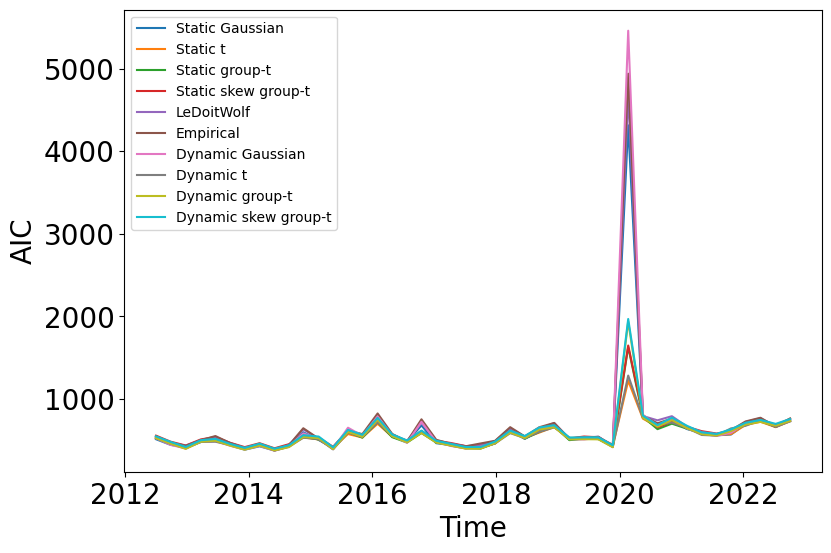

In [22]:
fig, ax = plt.subplots(1,1, figsize = (9,6))
k = str('0.1')
plot_stat_t('future_AIC', 9, [sgaussian, st, sgt, ssgt, ledoitwolf, empirical, dgaussian_ew[k], dt_ew[k],  dgt_ew[k], dsgt_ew[k]], 
                                 ['Static Gaussian', 'Static t', 'Static group-t', 'Static skew group-t', 'LeDoitWolf', 'Empirical', 'Dynamic Gaussian', 'Dynamic t', 'Dynamic group-t', 'Dynamic skew group-t'], ax = ax)
ax.set_title("")
ax.set_ylabel("AIC", fontdict = {'fontsize':20})
ax.set_xlabel(r"Time", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper left')
#ax.set_xlim([datetime.date(2018,1,1), datetime.date(2022,1,1)])

In [77]:
dt_ew['0.1']['portfolio_s'][9]

KeyError: 'portfolio_s'

In [75]:
print(np.prod(1+np.array(uniform_dict['mus_s'][9])))
print(np.prod(1+np.array(dt_ew['0.1']['mus_s'][0])))

6.06249137142725
19.925195066168424


0
1
2
3


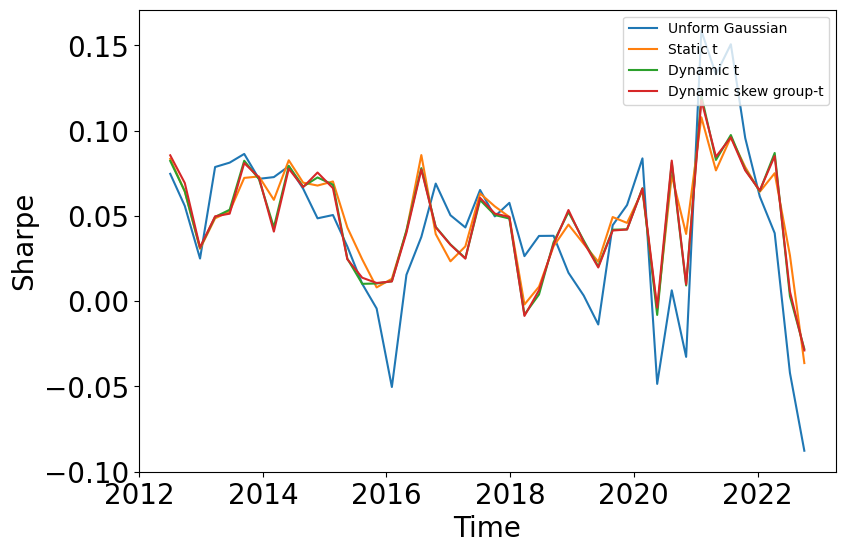

In [59]:
fig, ax = plt.subplots(1,1, figsize = (9,6))
k = str('0.1')
plot_stat_t('mus_m', 9, [uniform_dict, st, dt_ew['0.1'], dsgt_ew['0.1']], 
                                 ['Unform Gaussian', 'Static t', 'Dynamic t', 'Dynamic skew group-t'], ax = ax)
ax.set_title("")
ax.set_ylabel("Sharpe", fontdict = {'fontsize':20})
ax.set_xlabel(r"Time", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper right')
#ax.set_xlim([datetime.date(2018,1,1), datetime.date(2022,1,1)])

In [40]:
np.std(dt_ew['0.1']['sharpes_m'][9])

0.06460748312470602

In [43]:
print((np.mean(dt_ew['0.1']['sharpes_m'][9]), np.std(dt_ew['0.1']['sharpes_m'][9])))
print((np.mean(dt_ew['0.1']['sharpes_s'][9]), np.std(dt_ew['0.1']['sharpes_s'][9])))
print((np.mean(uniform_dict['sharpes_m'][9]), np.std(uniform_dict['sharpes_m'][9])))

(0.0517646120320101, 0.06460748312470602)
(0.04477930274492761, 0.05974454431661106)
(0.044311719440913264, 0.05995080581358758)


In [46]:
print((np.mean(dt_ew['0.1']['omegas_m'][9]), np.std(dt_ew['0.1']['omegas_m'][9])))
print((np.mean(dt_ew['0.1']['omegas_s'][9]), np.std(dt_ew['0.1']['omegas_s'][9])))
print((np.mean(uniform_dict['omegas_m'][9]), np.std(uniform_dict['omegas_m'][9])))

(1.2922723020693043, 0.35864148635875015)
(1.2433898988129528, 0.32003561507114764)
(1.2504811909194067, 0.32061600851904265)


## Plot Graph and graph statistic with vix

In [80]:
import yfinance as yf

ticker_list = ['^VIX']
start_date= "2012-07-01"
end_date="2023-02-01"

VIX = yf.download(ticker_list, start_date , end_date)

[*********************100%%**********************]  1 of 1 completed


In [87]:

def find_degree(obj, a = 9):
    avg_dgs_g_neg = []
    avg_dgs_g_pos = []
    for i in range(len(sgaussian['thetas'][1])):
        G = obj['thetas'][9][i][-1].copy()

        G_neg = -G.copy()
        G_neg[G_neg>0] = 0
        G_neg[np.abs(G_neg)<1e-2] = 0
        np.fill_diagonal(G_neg,0)
        G_neg = nx.from_numpy_array(G_neg)
        avg_dgs_g_neg.append(sum(dict(G_neg.degree(weight='weight')).values())/G_neg.number_of_nodes())

        G_pos = -G.copy()
        G_pos[G_pos<0] = 0
        G_pos[np.abs(G_pos)<1e-2] = 0
        np.fill_diagonal(G_pos,0)
        G_pos = nx.from_numpy_array(G_pos)
        avg_dgs_g_pos.append(sum(dict(G_pos.degree(weight='weight')).values())/G_pos.number_of_nodes())

    return avg_dgs_g_pos, avg_dgs_g_neg


avg_dgs_g_pos, avg_dgs_g_neg = find_degree(sgaussian)
avg_dgs_t_pos, avg_dgs_t_neg = find_degree(st)
avg_dgs_dg_pos, avg_dgs_dg_neg = find_degree(dgaussian_ew['0.1'])
avg_dgs_dt_pos, avg_dgs_dt_neg = find_degree(dt_ew['0.1'])
avg_dgs_dgt_pos, avg_dgs_dgt_neg = find_degree(dgt_ew['0.1'])
avg_dgs_dsgt_pos, avg_dgs_dsgt_neg = find_degree(dsgt_ew['0.1'])





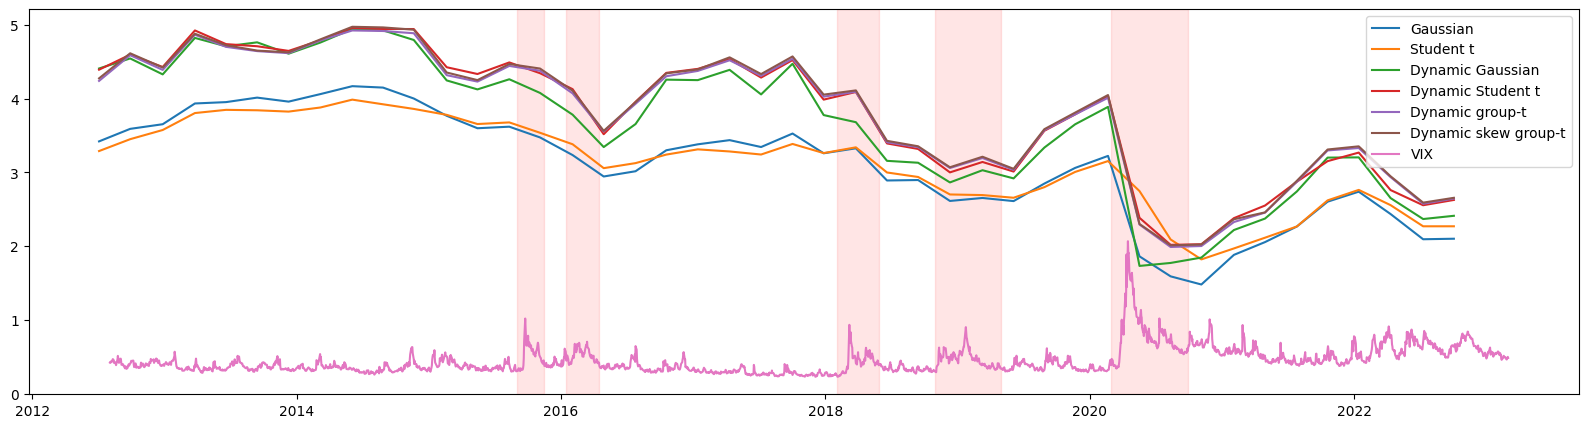

In [90]:
fig, ax = plt.subplots(1,1, figsize = (20,5))

ax.plot(st['time_change'], avg_dgs_g_pos, label = 'Gaussian')
ax.plot(sgaussian['time_change'], avg_dgs_t_pos, label = 'Student t')
ax.plot(sgaussian['time_change'], avg_dgs_dg_pos, label = 'Dynamic Gaussian')
ax.plot(sgaussian['time_change'], avg_dgs_dt_pos, label = 'Dynamic Student t')
ax.plot(sgaussian['time_change'], avg_dgs_dgt_pos, label = 'Dynamic group-t')
ax.plot(sgaussian['time_change'], avg_dgs_dsgt_pos, label = 'Dynamic skew group-t')
ax.plot(VIX.index + np.timedelta64(1, 'M'), VIX['Adj Close']/40, label = 'VIX')
ax.axvspan(pd.to_datetime(["2020-03-01"])[0], pd.to_datetime(["2020-09-30"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2018-02-01"])[0], pd.to_datetime(["2018-05-30"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2018-11-01"])[0], pd.to_datetime(["2019-04-30"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2015-09-01"])[0], pd.to_datetime(["2015-11-15"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2016-01-15"])[0], pd.to_datetime(["2016-04-15"])[0], alpha=0.1, color='red')
ax.legend()

In [240]:
sgaussian['time_change']

DatetimeIndex(['2012-07-03', '2012-09-27', '2012-12-26', '2013-03-25',
               '2013-06-19', '2013-09-13', '2013-12-09', '2014-03-07',
               '2014-06-03', '2014-08-27', '2014-11-20', '2015-02-19',
               '2015-05-15', '2015-08-11', '2015-11-04', '2016-02-02',
               '2016-04-28', '2016-07-25', '2016-10-18', '2017-01-13',
               '2017-04-11', '2017-07-07', '2017-10-02', '2017-12-27',
               '2018-03-26', '2018-06-20', '2018-09-14', '2018-12-11',
               '2019-03-11', '2019-06-05', '2019-08-29', '2019-11-22',
               '2020-02-21', '2020-05-18', '2020-08-12', '2020-11-05',
               '2021-02-03', '2021-04-30', '2021-07-27', '2021-10-20',
               '2022-01-14', '2022-04-12', '2022-07-11', '2022-10-04'],
              dtype='datetime64[ns]', name='Date', freq=None)

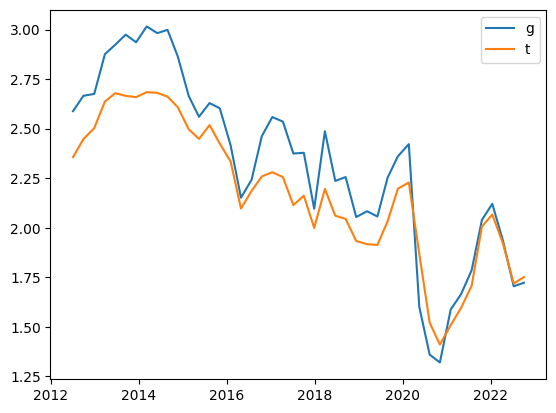

In [88]:
plt.plot(sgaussian['time_change'], avg_dgs_g, label = 'g')
plt.plot(sgaussian['time_change'], avg_dgs_t, label = 't')
plt.legend()

In [110]:
sgaussian['ticker_list']

array(['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB',
       'IYR', 'XTL'], dtype='<U3')

## Plot sample graphs

In [112]:
G = sgaussian['thetas'][6][40][-1].copy()
G = np.abs(G)
G = nx.from_numpy_array(G)
G.edges(data = 'weight')

EdgeDataView([(0, 0, 0.5466566228119876), (0, 1, 0.37292077266100054), (0, 2, 0.02040134207371609), (0, 3, 0.08883647517107288), (0, 4, 1.5173183760629521e-05), (0, 5, 1.7797535627462068e-05), (0, 6, 0.02378165465886965), (0, 7, 3.302685042449233e-07), (0, 8, 0.14994640861406847), (0, 9, 1.2863446418049078e-05), (0, 10, 0.06809044711847499), (1, 1, 1.4951213941561246), (1, 2, 5.082973635764519e-06), (1, 3, 0.5238588604607891), (1, 4, 7.034145388682588e-06), (1, 5, 6.035945495751526e-06), (1, 6, 0.05314366985976775), (1, 7, 0.0459821487761512), (1, 8, 0.28136497428760526), (1, 9, 5.666041440793593e-06), (1, 10, 0.06075637662603534), (2, 2, 1.3528529451886286), (2, 3, 0.040915578776161636), (2, 4, 2.8099169549637788e-05), (2, 5, 0.11848618539317579), (2, 6, 1.4904940632488726e-05), (2, 7, 0.46272289166844266), (2, 8, 1.1154679237630351e-05), (2, 9, 0.3574813333989511), (2, 10, 1.1363610516141236e-05), (3, 3, 1.9718286230959938), (3, 4, 0.03785377306912859), (3, 5, 2.87097748201869e-06), 

In [223]:


def plot_graph(G, ax = None, pos = None):

    if ax is None:
        fig, ax = plt.subplots(1,1)

    G_abs = np.abs(G)
    np.fill_diagonal(G,0)
    G[np.abs(G)<1e-2] = 0
    G = nx.from_numpy_array(G)
    G_abs = nx.from_numpy_array(G_abs)

    if pos is None:
        pos = nx.spring_layout( G_abs, weight=None)

    pos_edge = [(edge[0], edge[1]) for edge in G.edges(data = 'weight') if np.sign(edge[2]) == 1]
    neg_edge = [(edge[0], edge[1]) for edge in G.edges(data = 'weight') if np.sign(edge[2]) == -1]

    pos_width = [ w[2]*5 for w in G.edges(data = 'weight') if np.sign(w[2]) == 1]
    neg_width = [ -w[2]*5 for w in G.edges(data = 'weight') if np.sign(w[2]) == -1]

    widths = nx.get_edge_attributes(G, 'weight')

    nx.draw_networkx_nodes(G, pos, node_color= 'lightblue', ax = ax)
    #nx.draw_networkx_labels(G,pos,{i:i for i in range(len(scale_F_nonparanormal['stock_partition'][esg_port][graph_nr]))},ax = ax)
    nx.draw_networkx_labels(G,pos, {cnt:v for cnt,v in enumerate(sgaussian['ticker_list'])},ax = ax, font_size = 12)
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=pos_edge,
        width=pos_width,
        alpha=0.5,
        edge_color="tab:green",
        ax = ax
    )

    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=neg_edge,
        width=neg_width,
        alpha=0.5,
        edge_color="tab:red",
        ax = ax
    )

In [152]:
sgaussian['time_change'][32]

Timestamp('2020-02-21 00:00:00')

In [ ]:
sgt

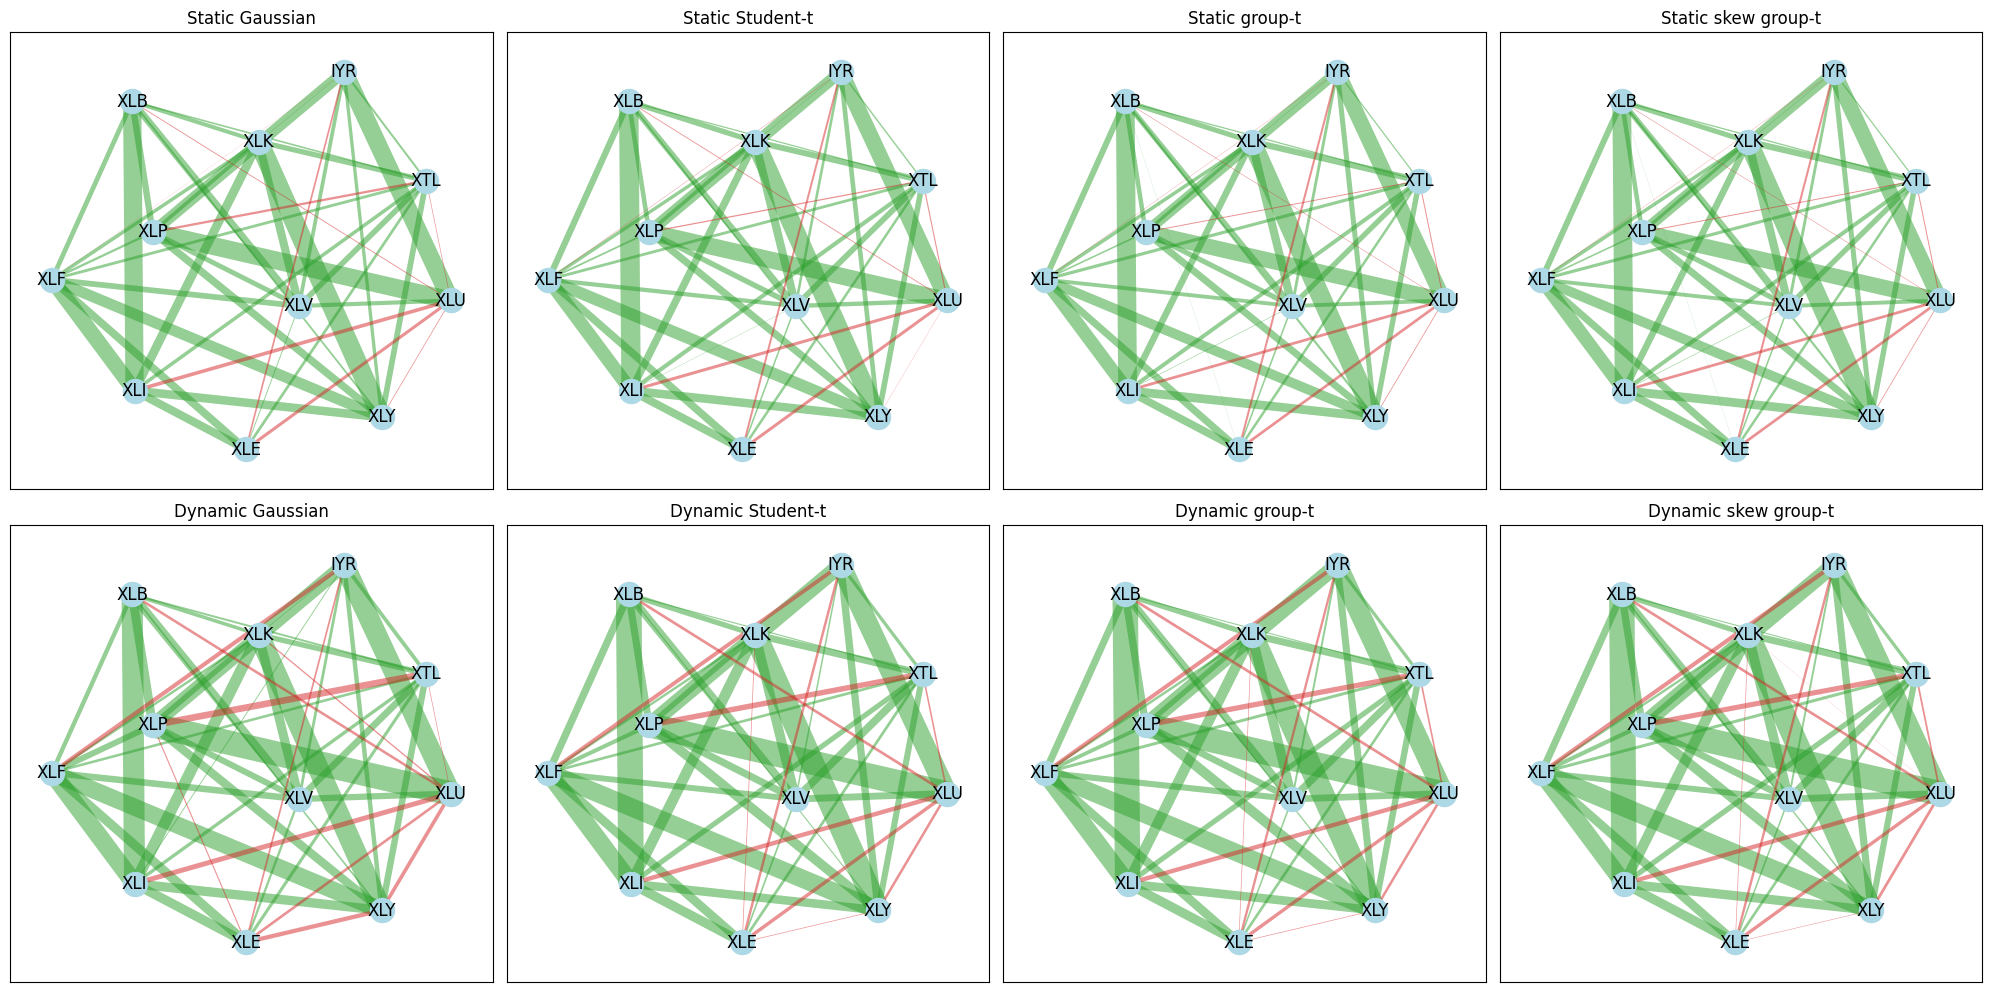

In [199]:
fig, axs = plt.subplots(2,4, figsize = (20,10))

G = -sgaussian['thetas'][6][10][-1].copy()
G_abs = np.abs(G)
np.fill_diagonal(G,0)
G = nx.from_numpy_array(G)
G_abs = nx.from_numpy_array(G_abs)

pos = nx.spring_layout( G_abs, weight=None)

# plot_graph(-sgaussian['thetas'][6][10][-1].copy(), axs[0,0], pos)
# plot_graph(-st['thetas'][6][10][-1].copy(), axs[1,0], pos)
# plot_graph(-sgt['thetas'][6][10][-1].copy(), axs[2,0], pos)

# plot_graph(-sgaussian['thetas'][6][32][-1].copy(), axs[0,1], pos)
# plot_graph(-st['thetas'][6][32][-1].copy(), axs[1,1], pos)
# plot_graph(-sgt['thetas'][6][32][-1].copy(), axs[2,1], pos)

a_id = 9
t = 32
plot_graph(-sgaussian['thetas'][a_id][t][-1].copy(), axs[0,0], pos)
axs[0,0].set_title("Static Gaussian")
plot_graph(-st['thetas'][a_id][t][-1].copy(), axs[0,1], pos)
axs[0,1].set_title("Static Student-t")
plot_graph(-sgt['thetas'][a_id][t][-1].copy(), axs[0,2], pos)
axs[0,2].set_title("Static group-t")
plot_graph(-ssgt['thetas'][a_id][t][-1].copy(), axs[0,3], pos)
axs[0,3].set_title("Static skew group-t")

plot_graph(-dgaussian_ew['0.1']['thetas'][a_id][t][-1].copy(), axs[1,0], pos)
axs[1,0].set_title("Dynamic Gaussian")
plot_graph(-dt_ew['0.1']['thetas'][a_id][t][-1].copy(), axs[1,1], pos)
axs[1,1].set_title("Dynamic Student-t")
plot_graph(-dgt_ew['0.1']['thetas'][a_id][t][-1].copy(), axs[1,2], pos)
axs[1,2].set_title("Dynamic group-t")
plot_graph(-dsgt_ew['0.1']['thetas'][a_id][t][-1].copy(), axs[1,3], pos)
axs[1,3].set_title("Dynamic skew group-t")

fig.tight_layout(pad=1)

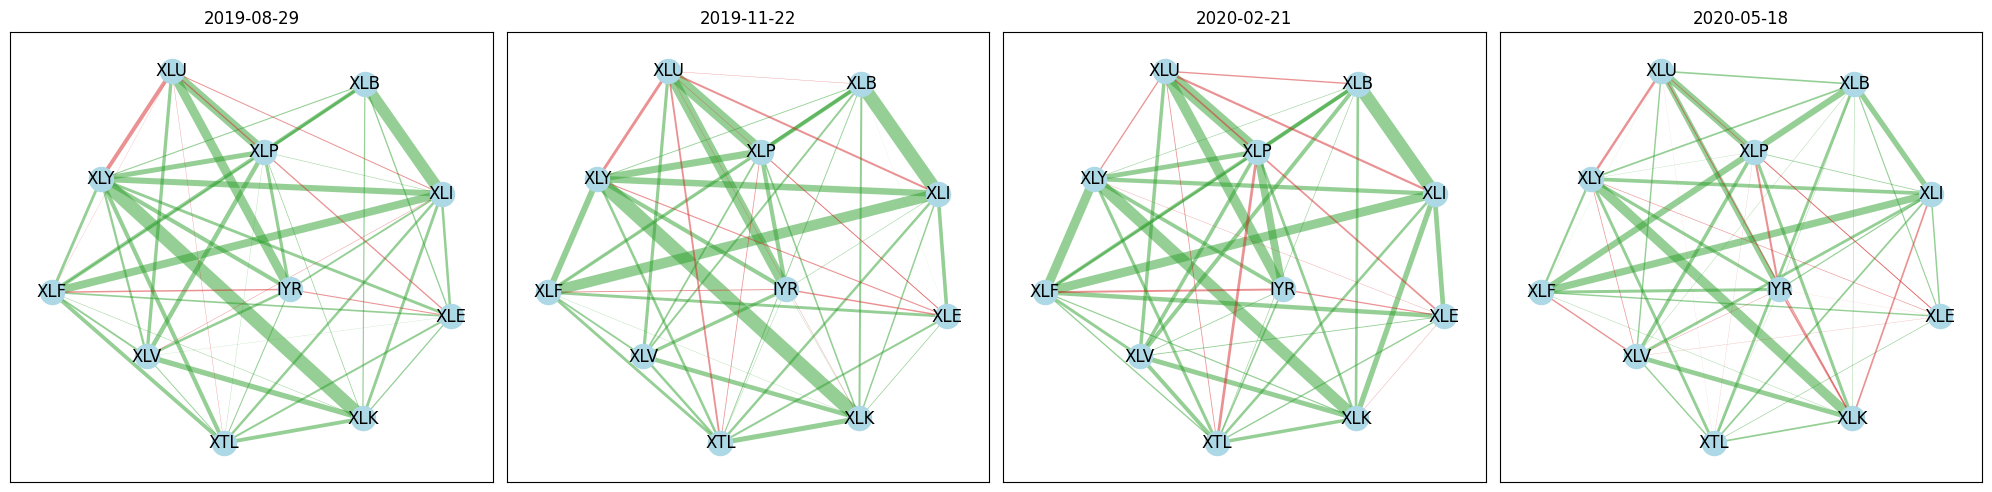

In [224]:
fig, axs = plt.subplots(1,4, figsize = (20,5))

G = -sgaussian['thetas'][6][10][-1].copy()
G_abs = np.abs(G)
np.fill_diagonal(G,0)
G = nx.from_numpy_array(G)
G_abs = nx.from_numpy_array(G_abs)

pos = nx.spring_layout( G_abs, weight=None)

# plot_graph(-sgaussian['thetas'][6][10][-1].copy(), axs[0,0], pos)
# plot_graph(-st['thetas'][6][10][-1].copy(), axs[1,0], pos)
# plot_graph(-sgt['thetas'][6][10][-1].copy(), axs[2,0], pos)

# plot_graph(-sgaussian['thetas'][6][32][-1].copy(), axs[0,1], pos)
# plot_graph(-st['thetas'][6][32][-1].copy(), axs[1,1], pos)
# plot_graph(-sgt['thetas'][6][32][-1].copy(), axs[2,1], pos)

a_id = 9



plot_graph(-dt_ew['0.1']['thetas'][a_id][30][-1].copy(), axs[0], pos)
axs[0].set_title(pd.to_datetime(dt_ew['0.1']['time_change'][30]).date())
plot_graph(-dt_ew['0.1']['thetas'][a_id][31][-1].copy(), axs[1], pos)
axs[1].set_title(pd.to_datetime(dt_ew['0.1']['time_change'][31]).date())
plot_graph(-dt_ew['0.1']['thetas'][a_id][32][-1].copy(), axs[2], pos)
axs[2].set_title(pd.to_datetime(dt_ew['0.1']['time_change'][32]).date())
plot_graph(-dt_ew['0.1']['thetas'][a_id][33][-1].copy(), axs[3], pos)
axs[3].set_title(pd.to_datetime(dt_ew['0.1']['time_change'][33]).date())

fig.tight_layout(pad=1)

In [218]:
pd.to_datetime(dt_ew['0.1']['time_change'][30]).date()

datetime.date(2019, 8, 29)

In [159]:
-sgaussian['thetas'][6][33][-1,0,:]

array([-2.87393650e-01,  1.57954673e-01, -6.79730016e-02,  1.25192847e-01,
       -2.64847462e-05,  7.77621809e-06,  4.82295125e-05, -3.32307838e-02,
        9.53732357e-02,  1.05679739e-05,  5.86112584e-02])

In [160]:
-st['thetas'][6][33][-1,0,:]

array([-3.70290488e-01,  1.70783466e-01, -4.90455347e-03,  1.37428203e-01,
       -1.56462173e-05, -2.31777212e-05,  3.84283181e-05, -3.40563116e-05,
        6.62909740e-02,  3.39650363e-05,  6.09651575e-02])

## Plot AIC

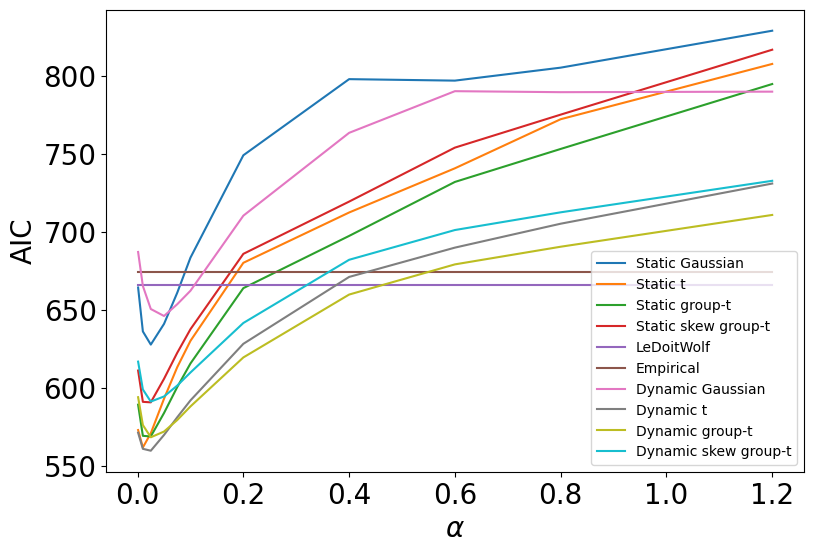

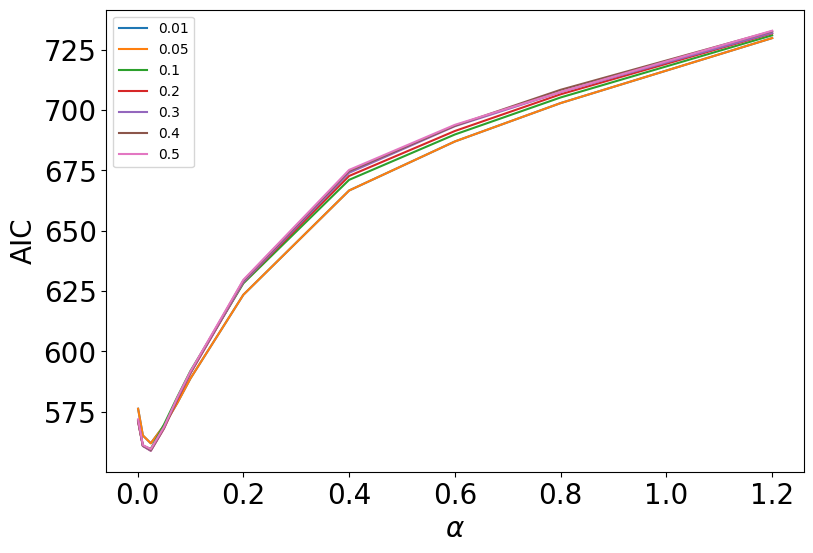

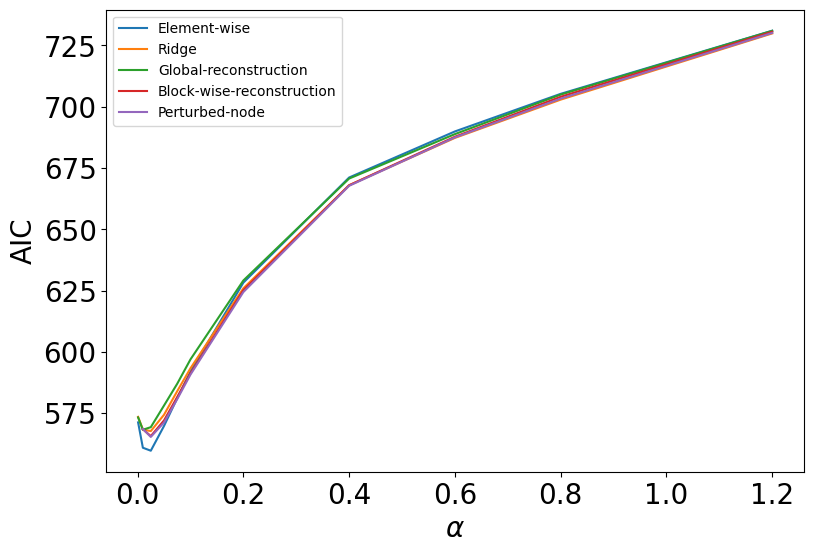

In [4]:
k = str(0.1)


fig, ax = plt.subplots(1,1, figsize = (9,6))
var_agg, var_agg_std = plot_stat('future_AIC', [sgaussian, st, sgt, ssgt, ledoitwolf, empirical, dgaussian_ew[k], dt_ew[k],  dgt_ew[k], dsgt_ew[k]], 
                                 ['Static Gaussian', 'Static t', 'Static group-t', 'Static skew group-t', 'LeDoitWolf', 'Empirical', 'Dynamic Gaussian', 'Dynamic t', 'Dynamic group-t', 'Dynamic skew group-t'], ax = ax)
ax.set_title("")
ax.set_ylabel("AIC", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'lower right')

# fig, ax = plt.subplots(1,1, figsize = (9,6))
# var_agg, var_agg_std = plot_stat('future_AIC', [dgaussian_ew[k],dt_ew[k], dgt_ew[k], dsgt_ew[k] ], 
#                                  ['Dynamic Gaussian', 'Dynamic t',  'Dynamic group t', 'Dynamic skew group t'], ax = ax)
# ax.set_title("")
# ax.set_ylabel("AIC", fontdict = {'fontsize':20})
# ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
# ax.tick_params(axis='both', which='major', labelsize=20)
# ax.legend(loc = 'upper left')




fig, ax = plt.subplots(1,1, figsize = (9,6))
var_agg, var_agg_std = plot_stat('future_AIC', [dt_ew[str(0.01)], dt_ew[str(0.01)], dt_ew[str(0.1)],dt_ew[str(0.2)],dt_ew[str(0.3)],dt_ew[str(0.4)],dt_ew[str(0.5)] ], 
                                 ['0.01', '0.05','0.1', '0.2', '0.3', '0.4', '0.5'], ax = ax)
ax.set_title("")
ax.set_ylabel("AIC", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper left')



k = str(0.1)
fig, ax = plt.subplots(1,1, figsize = (9,6))
var_agg, var_agg_std = plot_stat('future_AIC', [dt_ew[k], dt_ridge[k], dt_gr[k], dt_bwr[k], dt_pn[k]], 
                                 ['Element-wise', 'Ridge', 'Global-reconstruction', 'Block-wise-reconstruction', 'Perturbed-node'], ax = ax)
ax.set_title("")
ax.set_ylabel("AIC", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper left')

## Plot Nr params

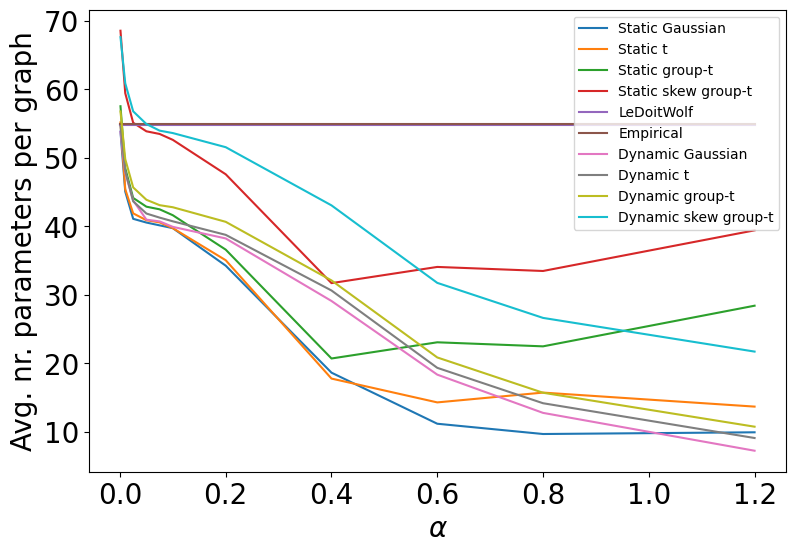

In [8]:
fig, ax = plt.subplots(1,1, figsize = (9,6))
k = str('0.1')
var_agg, var_agg_std = plot_stat('nr_params', [sgaussian, st, sgt, ssgt, ledoitwolf, empirical, dgaussian_ew[k], dt_ew[k],  dgt_ew[k], dsgt_ew[k]], 
                                 ['Static Gaussian', 'Static t', 'Static group-t', 'Static skew group-t', 'LeDoitWolf', 'Empirical', 'Dynamic Gaussian', 'Dynamic t', 'Dynamic group-t', 'Dynamic skew group-t'], ax = ax)
ax.set_title("")
ax.set_ylabel("Avg. nr. parameters per graph", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper right')




## Plot number of changes through time

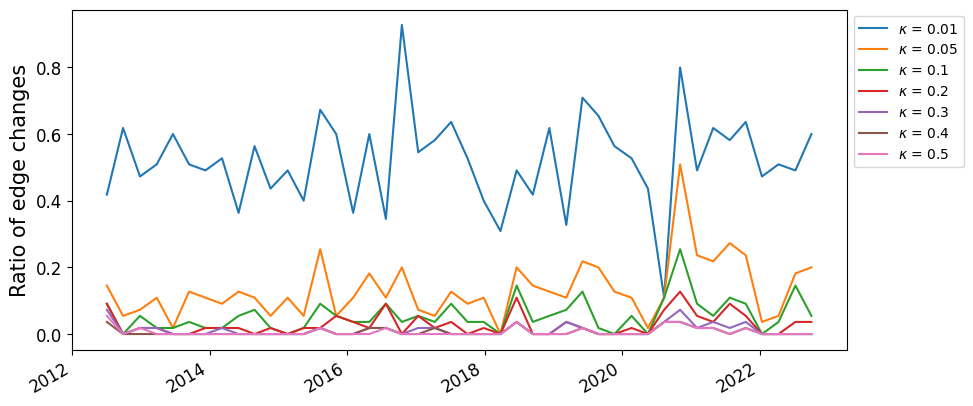

In [9]:
def nr_diff_elements(x,y,tol = 1e-1):
    A = x[np.triu_indices(x.shape[0], 1)]-y[np.triu_indices(x.shape[0], 1)]
    return np.sum(np.abs(A)>1e-2)

k = str(0.5)
nr_diff_elements_arr = np.zeros((len(dt_ew), len(dt_ew[k]['thetas']), len(dt_ew[k]['thetas'][0])))

for k, key in enumerate(dt_ew.keys()):
    for i in range(nr_diff_elements_arr.shape[1]):
        for j in range(nr_diff_elements_arr.shape[2]):
            #nr_diff_elements_arr[k,i,j] = np.sum([np.linalg.norm(dt_ew[key]['thetas'][i][j][s+1]-dt_ew[key]['thetas'][i][j][s]) for s in range(1)])
            nr_diff_elements_arr[k,i,j] = np.sum([np.abs(dt_ew[key]['thetas'][i][j][s+1])-np.abs(dt_ew[key]['thetas'][i][j][s] ) > 0.1 for s in range(1)])

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k, key in enumerate(dt_ew.keys()):
    ax.plot(dt_ew[key]['time_change'], nr_diff_elements_arr[k,-2]/(11*10/2),label = r'$\kappa$ = ' + str(key) )
ax.set_ylabel("Ratio of edge changes", fontdict = {'fontsize':15})
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
#ax.xaxis.set_tick_params(rotation=45)
ax.legend(bbox_to_anchor = (1,1))
ax.tick_params(axis='both', which='major', labelsize=12)

## Plot portfolio statistics




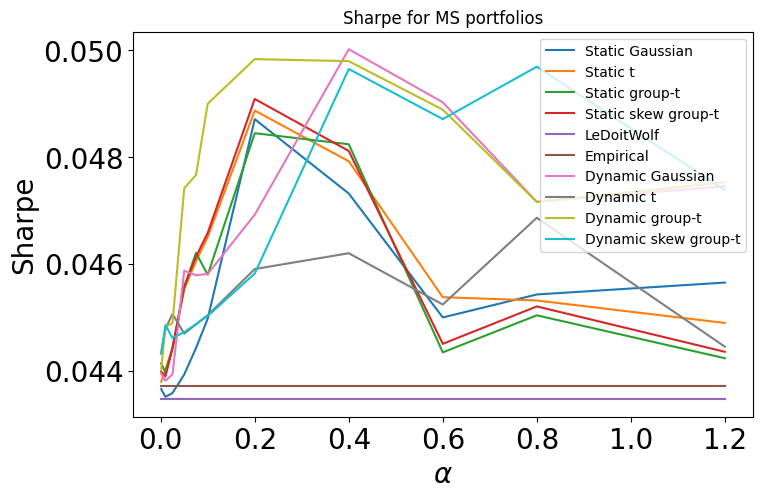

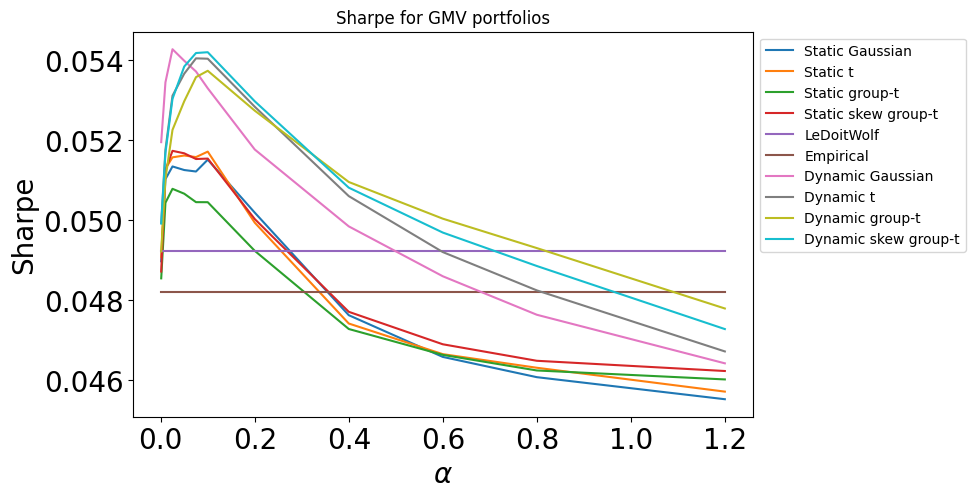

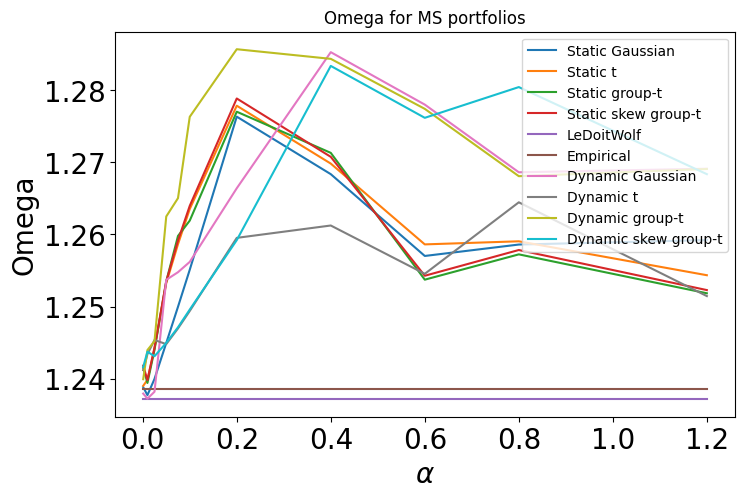

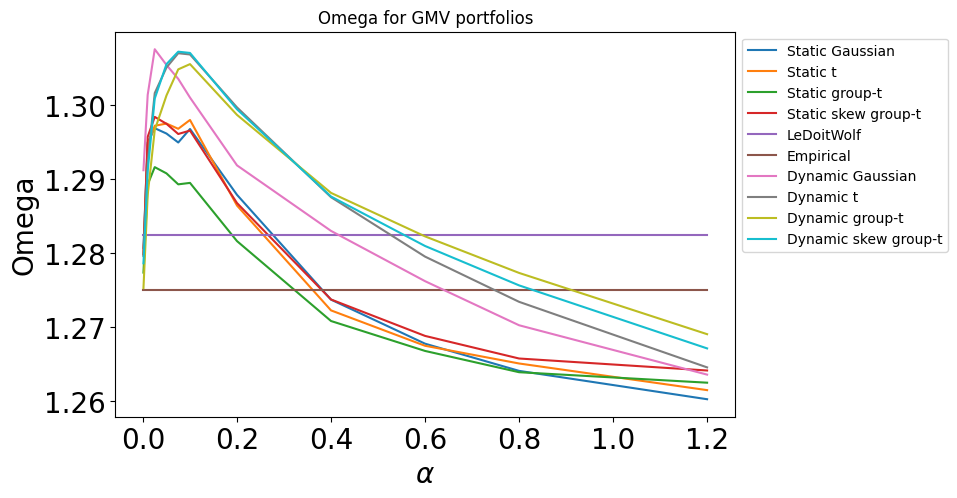

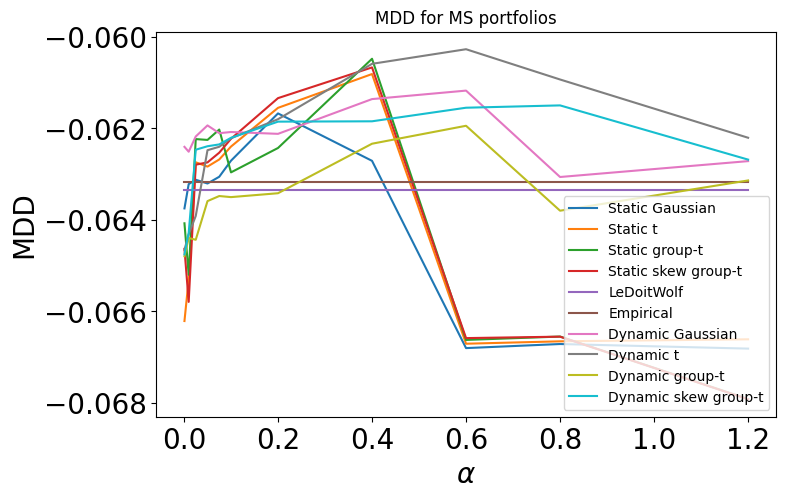

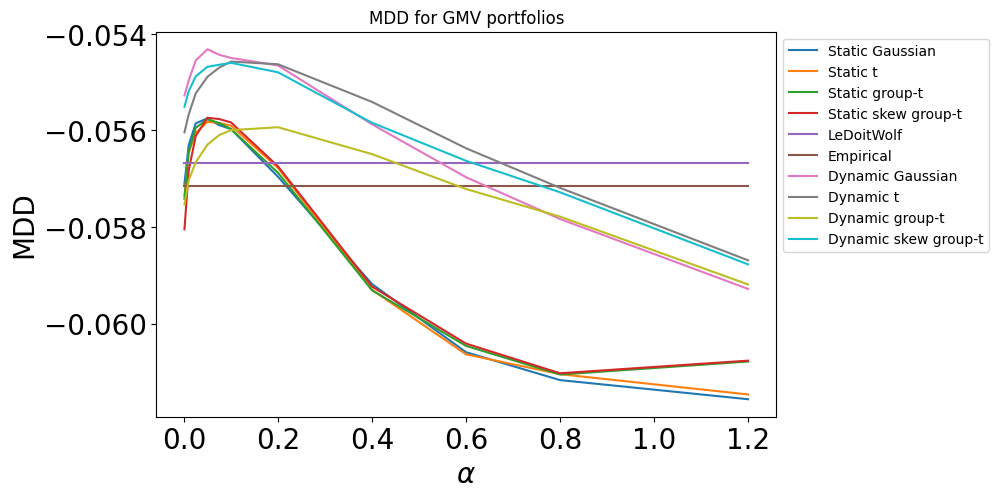

In [33]:
k = str(0.1)
args = [sgaussian, st, sgt, ssgt, ledoitwolf, empirical, dgaussian_ew[k], dt_ew[k], dgt_ew[k], dsgt_ew[k]]
labels = ['Static Gaussian', 'Static t', 'Static group-t', 'Static skew group-t', 'LeDoitWolf', 'Empirical', 'Dynamic Gaussian', 'Dynamic t', 'Dynamic group-t', 'Dynamic skew group-t']
fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('sharpes_s', args, 
                                 labels, ax = ax)
ax.set_title("Sharpe for MS portfolios")
ax.set_ylabel("Sharpe", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('sharpes_m', args, 
                                 labels, ax = ax)
ax.set_title("Sharpe for GMV portfolios")
ax.set_ylabel("Sharpe", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(bbox_to_anchor = (1,1))

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('omegas_s', args, 
                                 labels, ax = ax)
ax.set_title("Omega for MS portfolios")
ax.set_ylabel("Omega", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('omegas_m', args, 
                                 labels, ax = ax)
ax.set_title("Omega for GMV portfolios")
ax.set_ylabel("Omega", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(bbox_to_anchor = (1,1))

fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('mdds_s', args, 
                                 labels, ax = ax)
ax.set_title("MDD for MS portfolios")
ax.set_ylabel("MDD", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend()



fig, ax = plt.subplots(1,1, figsize = (8,5))
var_agg, var_agg_std = plot_stat('mdds_m', args, 
                                 labels, ax = ax)
ax.set_title("MDD for GMV portfolios")
ax.set_ylabel("MDD", fontdict = {'fontsize':20})
ax.set_xlabel(r"$\alpha$", fontdict = {'fontsize':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(bbox_to_anchor = (1,1))


## Price processes

In [48]:
import yfinance as yf

ticker_list = ['^GSPC']
groups = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
start_date= "2012-07-01"
end_date="2023-02-01"

data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]
def cum_prod_port(x):
    return np.cumprod(np.concatenate([(1+pd.DataFrame(x[i]).pct_change()).dropna() for i in range(len(x))]))

[*********************100%%**********************]  1 of 1 completed


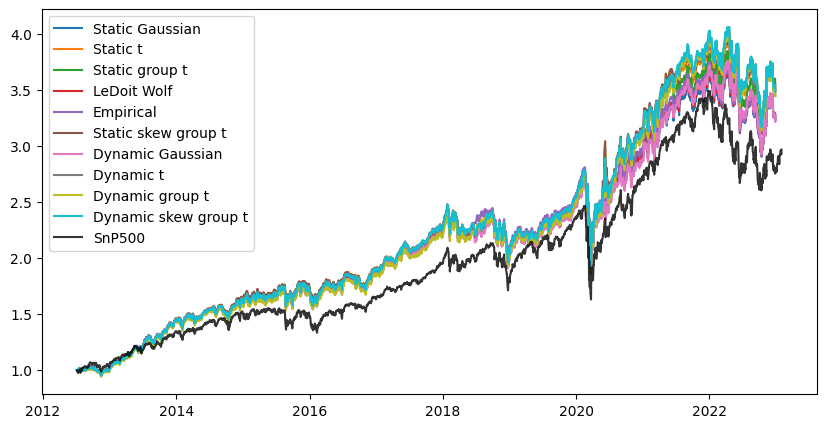

In [51]:
def cum_prod_port(x):
    #return ([np.cumprod((1+pd.DataFrame(x[i]).pct_change()).dropna()) for i in range(len(x))][0]).cumprod()
    return np.cumprod(np.concatenate([(1+pd.DataFrame(x[i]).pct_change()).dropna() for i in range(len(x))]))


#static_gaussian_port_info, static_t_port_info, static_gt_port_info, d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4']

price_id = 'port_price_s'
s_n_price = cum_prod_port(sgaussian[price_id][9])  #np.cumprod(1+np.array(static_t_port_info['rs_s'][3]))# 
s_t_price = cum_prod_port(st[price_id][9]) 
s_gt_price = cum_prod_port(sgt[price_id][9]) 
s_sgt_price = cum_prod_port(ssgt[price_id][9]) 
lewolf_price = cum_prod_port(ledoitwolf[price_id][9]) 
emp_price = cum_prod_port(empirical[price_id][9]) 
d_n_price = cum_prod_port(dgaussian_ew['0.1'][price_id][9])  #np.cumprod(1+np.array(static_t_port_info['rs_s'][3]))# 
d_t_price = cum_prod_port(dt_ew['0.1'][price_id][9]) 
d_gt_price = cum_prod_port(dgt_ew['0.1'][price_id][9]) 
d_sgt_price = cum_prod_port(dsgt_ew['0.1'][price_id][9]) 


#price = price.loc[np.isin(price.index)]

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]), s_n_price, label = 'Static Gaussian')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),s_t_price, label = 'Static t')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),s_gt_price, label = 'Static group t')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),lewolf_price, label = 'LeDoit Wolf')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),emp_price, label = 'Empirical')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),s_sgt_price, label = 'Static skew group t')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),d_n_price, label = 'Dynamic Gaussian')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),d_t_price, label = 'Dynamic t')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),d_gt_price, label = 'Dynamic group t')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),d_sgt_price, label = 'Dynamic skew group t')
ax.plot((1+price.pct_change()).index, np.cumprod(1+price.pct_change()), label = 'SnP500', color = 'black', alpha = 0.8)
ax.legend()

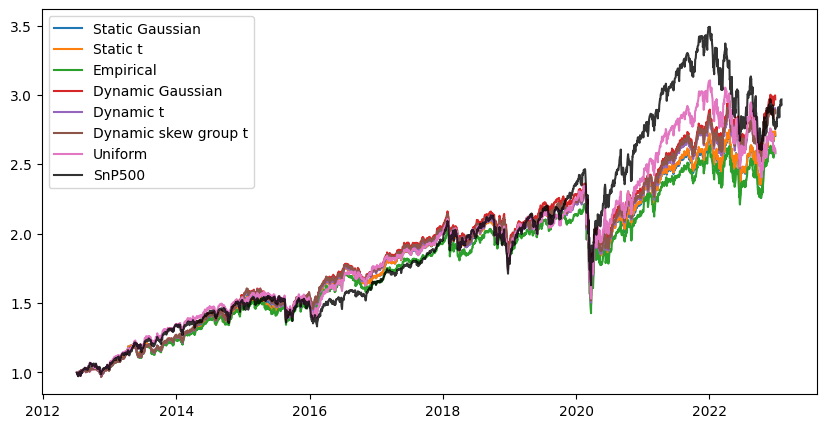

In [53]:
def cum_prod_port(x):
    #return ([np.cumprod((1+pd.DataFrame(x[i]).pct_change()).dropna()) for i in range(len(x))][0]).cumprod()
    return np.cumprod(np.concatenate([(1+pd.DataFrame(x[i]).pct_change()).dropna() for i in range(len(x))]))


#static_gaussian_port_info, static_t_port_info, static_gt_port_info, d_t_50_ew['0.4'],  d_gaussian_50_ew['0.4'], d_gt_50_ew['0.4']
price_id = 'port_price_m'
s_n_price = cum_prod_port(sgaussian[price_id][9])  #np.cumprod(1+np.array(static_t_port_info['rs_s'][3]))# 
s_t_price = cum_prod_port(st[price_id][9]) 
emp_price = cum_prod_port(empirical[price_id][9]) 
d_n_price = cum_prod_port(dgaussian_ew['0.1'][price_id][9])  #np.cumprod(1+np.array(static_t_port_info['rs_s'][3]))# 
d_t_price = cum_prod_port(dt_ew['0.1'][price_id][9]) 
d_sgt_price = cum_prod_port(dsgt_ew['0.1'][price_id][9]) 
uniform_price = cum_prod_port(uniform_dict[price_id][9]) 


#price = price.loc[np.isin(price.index)]

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]), s_n_price, label = 'Static Gaussian')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),s_t_price, label = 'Static t')
ax.plot(np.concatenate([dt[1:] for dt in sgaussian['time_forecast'][0]]),emp_price, label = 'Empirical')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),d_n_price, label = 'Dynamic Gaussian')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),d_t_price, label = 'Dynamic t')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),d_sgt_price, label = 'Dynamic skew group t')
ax.plot(np.concatenate([dt[1:] for dt in dt_ew['0.4']['time_forecast'][0]]),uniform_price, label = 'Uniform')
ax.plot((1+price.pct_change()).index, np.cumprod(1+price.pct_change()), label = 'SnP500', color = 'black', alpha = 0.8)
ax.legend()

# Pension funded vs unfunded

Read GDP

<Axes: xlabel='observation_date'>

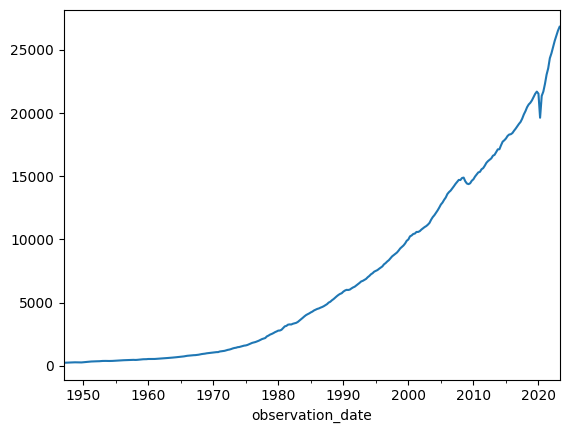

In [17]:
gdp = pd.read_excel("../data/GDP.xls",)
gdp.head()
gdp.index = gdp['observation_date']
gdp = gdp.iloc[:,1]
gdp.plot()

<Axes: xlabel='observation_date'>

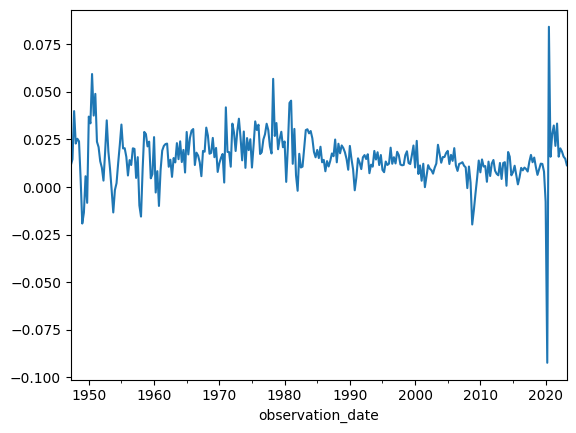

In [18]:
log_rgdp = np.log((1+gdp.pct_change())).dropna()
log_rgdp.plot() ## quarterly change

In [19]:
np.std(log_rgdp.iloc[300-100:300])*4

0.05894997601197678

Join daily dates and make daily return

<Axes: >

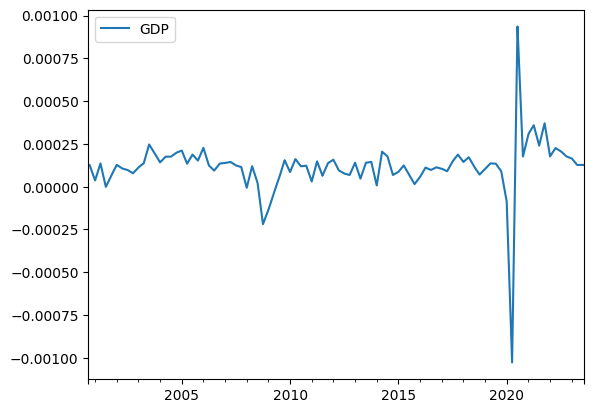

In [20]:
date_df = pd.DataFrame( index = pd.date_range(start="2000-09-09",end="2023-08-02"))
daily_log_rgdp = pd.merge(date_df,log_rgdp, left_index=True, right_index=True,  how = 'left')
daily_log_rgdp = daily_log_rgdp.interpolate()/90
daily_log_rgdp.plot()

In [21]:
with open(f'data/raw_etf2.pkl', 'rb') as handle:
    data = pickle.load(handle)

ticker_list = data['ticker_list']
log_returns_scaled = data['log_returns_scaled']
price = data['price']
groups = data['groups']


In [22]:


def fund_weights(obj, gamma, a_idx, log_rgdp):

    gdp_mu = []
    mu_r = []
    std_r = []
    gdp_std = []
    covar = []
    w_dew = []
    stds = log_rgdp.rolling(40).std()
    means = log_rgdp.rolling(40).mean()
    for cnt, (t,j) in enumerate(zip(obj['time_change'], obj['time_index'])):
        if cnt <=1:
            continue
        i = np.where(log_rgdp.index == min(log_rgdp.index, key=lambda d: abs(d-t)))[0][0] -1
        gdp_returns = daily_log_rgdp.iloc[i-40:i,0]
        gdp_mu.append(means[i]*4*100) ## annualized
        gdp_std.append(stds[i]*np.sqrt(4)*100 ) ## annualized


        w_s = obj['ws_s'][a_idx][cnt]
        past_price = np.dot(price.iloc[j-180:j],w_s)
        log_returns = np.array(np.log(1+pd.DataFrame(past_price).pct_change()).dropna())[:,0]
        mu_r.append(np.mean(log_returns)*250*100)
        std_r.append(np.std(log_returns)*np.sqrt(250)*100)

        
        past_price = price.iloc[j-60*6:j:60]
        log_returns = np.array(np.log(1+pd.DataFrame(past_price).pct_change()).dropna())[:,0]*100
        covar.append(np.cov((log_returns, np.array(log_rgdp.iloc[i-5:i])))[0,1])



    for i in range(len(covar)):
        w_dew.append((mu_r[i] - gdp_mu[i] + gamma*(gdp_std[i]**2 -covar[i] ) )/(gamma*(std_r[i]**2 + gdp_std[i]**2 - 2*covar[i])))

    return w_dew, gdp_mu, gdp_std,covar, mu_r, std_r

In [23]:
yc = pd.read_pickle("../CovRegressionPaper/yc/US.pkl")
spread = yc['10 Yr'].loc[(yc['2 Yr'] != '') & (yc['10 Yr'] != '')].astype(float) - yc['2 Yr'].loc[(yc['2 Yr'] != '') & (yc['10 Yr'] != '')].astype(float)
spread_time = pd.to_datetime(yc['Date'].loc[(yc['2 Yr'] != '') & (yc['10 Yr'] != '')])

In [24]:
import yfinance as yf

ticker_list = ['^VIX']
start_date= "2012-07-01"
end_date="2023-02-01"

VIX = yf.download(ticker_list, start_date , end_date)

[*********************100%***********************]  1 of 1 completed


In [25]:
ffinterest = pd.read_csv("../CovRegressionPaper/yc/FederalInterest.csv")

In [26]:
ffinterest.index = pd.to_datetime(ffinterest['Date'])

(15700.0, 19269.0)

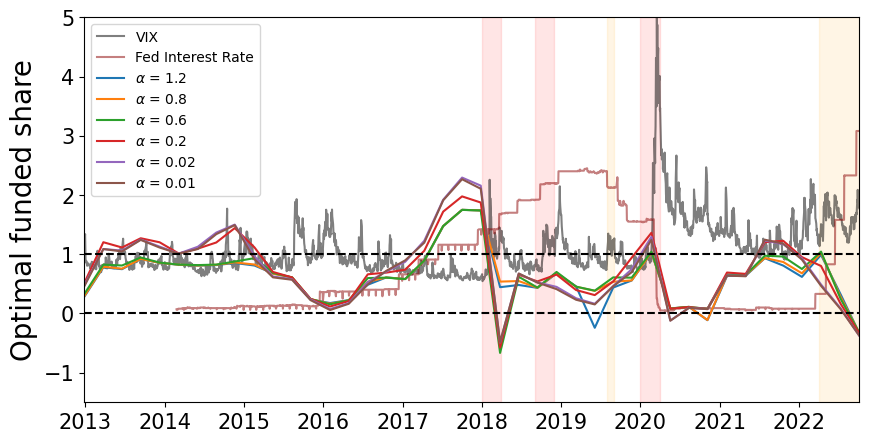

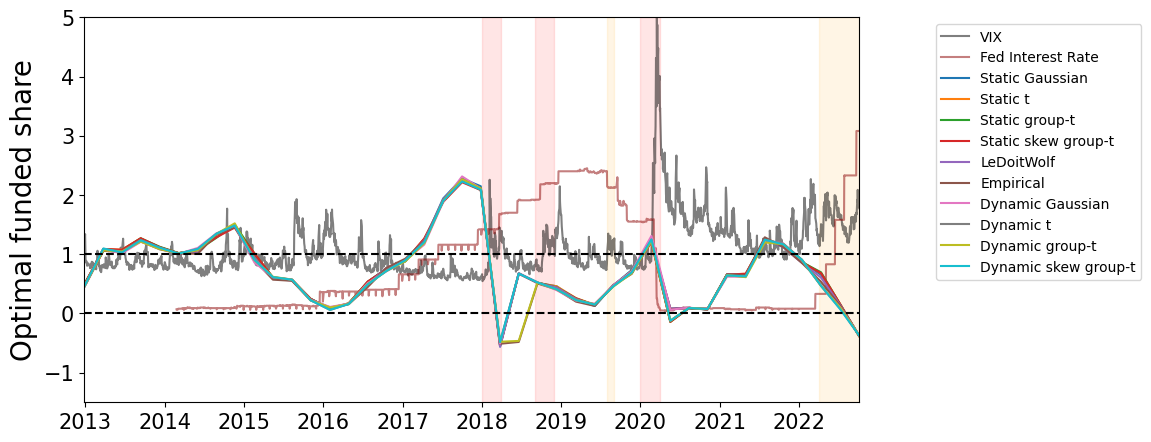

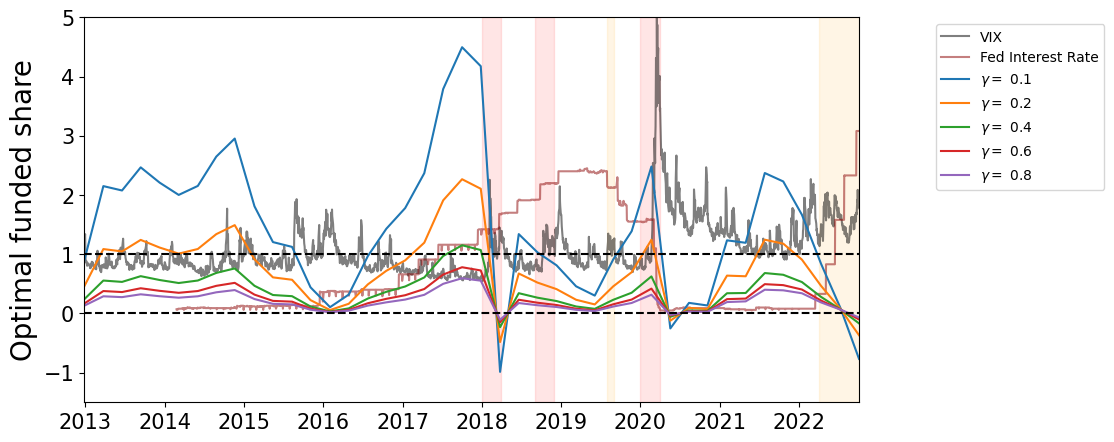

In [34]:




# Plot per alpha
fig, ax = plt.subplots(1,1, figsize = (10,5))
# ax.plot(spread_time.iloc[100:3000], spread.iloc[100:3000], alpha = 0.5, label = 'Spread')
ax.plot(VIX.index, 5*VIX['Open']/np.max(VIX['Open']), alpha = 0.5, label = 'VIX', color = 'black')
ax.plot(ffinterest.index, ffinterest['Open'], alpha = 0.5, label = 'Fed Interest Rate', color = 'darkred')

#ax.fill_between(pd.to_datetime(["2018-9-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
#ax.plot(pd.to_datetime(["2018-12-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
ax.axvspan(pd.to_datetime(["2018-01-01"])[0], pd.to_datetime(["2018-03-30"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2018-9-01"])[0], pd.to_datetime(["2018-12-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2020-01-01"])[0], pd.to_datetime(["2020-04-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2019-08-01"])[0], pd.to_datetime(["2019-09-01"])[0], alpha=0.1, color='orange')
ax.axvspan(pd.to_datetime(["2022-04-01"])[0], pd.to_datetime(["2023-09-01"])[0], alpha=0.1, color='orange')

for a_idx in [0, 1, 2, 4, 8, 9]:
    w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights(dt_ew['0.1'], 0.2, a_idx, log_rgdp)
    ax.plot(dt_ew['0.01']['time_change'][2:], w, label = r'$\alpha$ = ' + str(np.round(dt_ew['0.1']['alphas'][a_idx], 2)))


ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.set_ylim((-1.5, 5))
ax.legend(loc = 'upper left', fontsize = 10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel("Optimal funded share", fontdict = {'fontsize':20})
ax.set_xlim((np.min(dt_ew['0.01']['time_change'][2:]), np.max(dt_ew['0.01']['time_change'][2:])))


# plot per model 
k = str(0.1)
models = [sgaussian, st, sgt, ssgt, ledoitwolf, empirical, dgaussian_ew[k], dt_ew[k],  dgt_ew[k], dsgt_ew[k]]
labels = ['Static Gaussian', 'Static t', 'Static group-t', 'Static skew group-t', 'LeDoitWolf', 'Empirical', 'Dynamic Gaussian', 'Dynamic t', 'Dynamic group-t', 'Dynamic skew group-t']
fig, ax = plt.subplots(1,1, figsize = (10,5))

# ax.plot(spread_time.iloc[100:3000], spread.iloc[100:3000], alpha = 0.5, label = 'Spread')
ax.plot(VIX.index, 5*VIX['Open']/np.max(VIX['Open']), alpha = 0.5, label = 'VIX', color = 'black')
ax.plot(ffinterest.index, ffinterest['Open'], alpha = 0.5, label = 'Fed Interest Rate', color = 'darkred')

#ax.fill_between(pd.to_datetime(["2018-9-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
#ax.plot(pd.to_datetime(["2018-12-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
ax.axvspan(pd.to_datetime(["2018-01-01"])[0], pd.to_datetime(["2018-03-30"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2018-9-01"])[0], pd.to_datetime(["2018-12-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2020-01-01"])[0], pd.to_datetime(["2020-04-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2019-08-01"])[0], pd.to_datetime(["2019-09-01"])[0], alpha=0.1, color='orange')
ax.axvspan(pd.to_datetime(["2022-04-01"])[0], pd.to_datetime(["2023-09-01"])[0], alpha=0.1, color='orange')


for cnt  in range(len(models)):
    w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights(models[cnt], 0.2 , 9, log_rgdp)
    ax.plot(dt_ew['0.01']['time_change'][2:], w, label = labels[cnt] )
ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.set_ylim((-1.5, 5))
ax.legend(bbox_to_anchor = (1.09,1), fontsize = 10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel("Optimal funded share", fontdict = {'fontsize':20})
ax.set_xlim((np.min(dt_ew['0.01']['time_change'][2:]), np.max(dt_ew['0.01']['time_change'][2:])))

# Plot per gamma
fig, ax = plt.subplots(1,1, figsize = (10,5))


# ax.plot(spread_time.iloc[100:3000], spread.iloc[100:3000], alpha = 0.5, label = 'Spread')
ax.plot(VIX.index, 5*VIX['Open']/np.max(VIX['Open']), alpha = 0.5, label = 'VIX', color = 'black')
ax.plot(ffinterest.index, ffinterest['Open'], alpha = 0.5, label = 'Fed Interest Rate', color = 'darkred')

#ax.fill_between(pd.to_datetime(["2018-9-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
#ax.plot(pd.to_datetime(["2018-12-01", "2018-9-01"]), [-1 ,5], linestyle = '--')
ax.axvspan(pd.to_datetime(["2018-01-01"])[0], pd.to_datetime(["2018-03-30"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2018-9-01"])[0], pd.to_datetime(["2018-12-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2020-01-01"])[0], pd.to_datetime(["2020-04-01"])[0], alpha=0.1, color='red')
ax.axvspan(pd.to_datetime(["2019-08-01"])[0], pd.to_datetime(["2019-09-01"])[0], alpha=0.1, color='orange')
ax.axvspan(pd.to_datetime(["2022-04-01"])[0], pd.to_datetime(["2023-09-01"])[0], alpha=0.1, color='orange')


for gamma  in [0.1,0.2,0.4,0.6, 0.8]:
    w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights( dt_ew[str(0.1)], gamma , 9, log_rgdp)
    ax.plot(dt_ew['0.01']['time_change'][2:], w, label = r'$\gamma = $ ' + str(gamma) )
ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
ax.set_ylim((-1.5, 5))
ax.legend(bbox_to_anchor = (1.09,1), fontsize = 10)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel("Optimal funded share", fontdict = {'fontsize':20})
ax.set_xlim((np.min(dt_ew['0.01']['time_change'][2:]), np.max(dt_ew['0.01']['time_change'][2:])))

# # plot per kappa 
# fig, ax = plt.subplots(1,1, figsize = (10,5))
# for k_idx, k in enumerate(dt_ew.keys()):
#     w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights(dt_ew[k], 0.2 , 9, log_rgdp)
#     ax.plot(dt_ew['0.01']['time_change'][2:], w, label = r'$\kappa$ = ' + list(dt_ew.keys())[k_idx] )

# ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.set_ylabel("Optimal funded share")
# ax.legend()



# ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.set_ylabel("Optimal funded share")
# ax.legend()


# plot per penalty 
# k = str(0.1)
# models = [dt_ew[k], dt_ridge[k], dt_gr[k], dt_bwr[k], dt_pn[k]]
# labels = ['Element-wise', 'Ridge', 'Global-reconstruction', 'Block-wise-reconstruction', 'Perturbed-node']
# fig, ax = plt.subplots(1,1, figsize = (10,5))
# for cnt  in range(len(models)):
#     w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights(models[cnt], 0.2 , 9, log_rgdp)
#     ax.plot(dt_ew['0.01']['time_change'][2:], w, label = labels[cnt] )

# ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.set_ylabel("Optimal funded share")
# ax.legend()


# k = str(0.1)
# models = [dt_ew['0.1'], dt_ew['0.4']]
# labels = ['Element-wise', 'Ridge', 'Global-reconstruction', 'Block-wise-reconstruction', 'Perturbed-node']
# fig, ax = plt.subplots(1,1, figsize = (10,5))
# for cnt  in range(len(models)):
#     w, gdp_mu, gdp_std,covar, mu_r, std_r = fund_weights(models[cnt], 0.2 , 9, log_rgdp)
#     ax.plot(dt_ew['0.01']['time_change'][2:], w, label = labels[cnt] )

# ax.plot(dt_ew['0.01']['time_change'][2:], [1]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.plot(dt_ew['0.01']['time_change'][2:], [0]*len(dt_ew['0.01']['time_change'][2:]), linestyle = '--', color = 'black')
# ax.set_ylabel("Optimal funded share")
# ax.legend()


# fig, ax = plt.subplots(1,1, figsize = (10,5))
# ax.plot(dt_ew['0.01']['time_change'][2:],gdp_mu, label = 'mean gdp')
# ax.plot(dt_ew['0.01']['time_change'][2:],mu_r, label = 'Portfolio mean')
# ax.set_title("Mean")
# ax.legend()


# fig, ax = plt.subplots(1,1, figsize = (10,5))
# ax.plot(dt_ew['0.01']['time_change'][2:], gdp_std, label = 'gdp std')
# ax.plot(dt_ew['0.01']['time_change'][2:], std_r, label = 'Portfolio std')
# ax.plot(dt_ew['0.01']['time_change'][2:], covar, label = 'Covariance')

# ax.set_title("std")
# ax.legend()





